# Machine Learning Analysis

## Overview

The goal of this machine learning analysis is to develop a predictive model for estimating real estate listing prices in Utah. We’ll employ a variety of regression techniques, including Linear Regression, Decision Trees, and Ensemble methods, to assess model accuracy and identify the best predictors of property price. By refining the model with features such as price-per-square-foot and property age, we aim to provide accurate and actionable insights that real estate professionals, investors, and analysts can use to gauge property values effectively.

As a reminder goal is to find out:

- Which features best predict listing prices.
- How accurately different models can predict these prices.
- How much we can improve accuracy by tuning models.

## Machine Learning Analysis Questions
- What are the best predictors of listing price among the property features?
- How accurately can we predict the list price based on property attributes?
- How do different regression models compare in predicting the listing price?
- What are the residuals and their distribution for the best-performing model?
- Does model performance improve significantly with hyperparameter tuning?

### Data Preparation

Data preparation is a crucial step where we get our data ready for modeling. This includes dividing the data into training and testing sets, scaling (or resizing) the numerical data, and encoding (or converting) the categorical data (like property type) into a format the model can understand.

In [74]:
#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


In [75]:
#Loading the Clean & Transformed Data
path = ('../data/cleaned_real_estate_utah.csv')
cleanedrs_data = pd.read_csv(path)

In [76]:
cleanedrs_data.head()

,type,text,year_built,beds,baths,baths_full,baths_half,garage,lot_sqft,sqft,...,type_condo_townhome_rowhome_coop,type_condos,type_farm,type_land,type_mobile,type_other,type_single_family,type_townhomes,type_townhouse,status_encoded
0,single_family,"Escape to tranquility with this off-grid, unfi...",2020.0,1.0,1.0,1.0,1.0,2.0,71438.0,696.0,...,False,False,False,False,False,False,True,False,False,0
1,single_family,Beautiful home in the desirable Oak Hills and ...,1968.0,4.0,3.0,2.0,1.0,2.0,56628.0,3700.0,...,False,False,False,False,False,False,True,False,False,0
2,single_family,"Welcome to your new home, nestled in the heart...",1985.0,4.0,3.0,3.0,1.0,1.0,10019.0,3528.0,...,False,False,False,False,False,False,True,False,False,0
3,single_family,Investment Opportunity. House needs some work ...,1936.0,4.0,2.0,2.0,1.0,2.0,12632.0,2097.0,...,False,False,False,False,False,False,True,False,False,0
4,land,Deer Springs Ranch is an 8000 Ac Ranch in an H...,2003.0,4.0,0.0,2.0,1.0,2.0,872071.0,2400.0,...,False,False,False,True,False,False,False,False,False,0


### Defining X and y
In the data preparation for machine learning, we need to specify:

- X: The features or independent variables, which will include all relevant property attributes that may predict listing price (like square footage, number of bedrooms, and any encoded columns for categorical features).
- y: The target or dependent variable, which in this case is the listing price (listPrice), as we are trying to predict this value.

In [77]:
# Define target variable y as the listing price
y = cleanedrs_data['listPrice']

# Define feature matrix X, selecting only the relevant columns
# Here we drop columns that aren't needed for prediction like 'listPrice' and the original categorical columns
X = cleanedrs_data.drop([
    'listPrice',           # Target variable
    'type',                # Original categorical column
    'status',              # Original categorical column
    'text',                # Text data
    'lastSoldOn',          # Date information, potentially unnecessary
    'type_comparison',     # Non-numeric comparison column
], axis=1)


We set y to be listPrice, as this is our target variable.
X includes all features, but excludes listPrice (since it’s our target) and the original unencoded columns for type and status, as we have already created encoded versions

### Splitting Data into Training & Testing Sets:
- The training set is used to teach the model.
- The testing set checks if the model can accurately predict new, unseen data.

In [78]:
# Split the data (assuming 'X' are the features and 'y' is the target variable, listPrice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We use 80% of our data for training and 20% for testing, which is common for predictive modeling.

### Scaling Numerical Features:
- To help the model perform better, we scale features like square footage, which might have a large range.

In [79]:
# Scale numerical features (fit on train data, transform on both train and test data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling makes sure that big numbers (like 2000 sqft) don’t overpower smaller numbers, helping the model learn relationships more effectively.

### Encoding Categorical Features
Since we handled encoding earlier, here’s how to confirm we’re using the processed data:

type_comparison and any additional one-hot columns we created for type are now in X.
status_encoded is also in X, which contains ordinal encoding for the status column.
If we did these steps earlier, we don’t need to encode type or status again. We can proceed directly to model training.

In [80]:
# #Example to Encode Categorical Features (already completed in data cleaning step 2.4)
# # Encode categorical features
# categorical_features = ['propertyType', 'status']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_features)],
#     remainder='passthrough')

# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)


Encoding converts text categories into numbers so the model can process them.

In [81]:
# Convert scaled data back to DataFrames with the original column names for easy reference
X_train_prepared = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_prepared = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Final Structure of X and y
This section ensures that we’re only using the encoded columns, without redundancies:

In [82]:
# Print a summary of X and y to verify
print("Features (X):", X.columns)
print("Target (y):", y.name)


Features (X): Index(['year_built', 'beds', 'baths', 'baths_full', 'baths_half', 'garage',
       'lot_sqft', 'sqft', 'stories', 'sold_year', 'sold_month', 'type_condo',
       'type_condo_townhome', 'type_condo_townhome_rowhome_coop',
       'type_condos', 'type_farm', 'type_land', 'type_mobile', 'type_other',
       'type_single_family', 'type_townhomes', 'type_townhouse',
       'status_encoded'],
      dtype='object')
Target (y): listPrice


This step confirms the columns in X match our expectations for the features we want to include and are ready for training.

By following these adjustments, our machine learning model should now use the prepared data directly, with all required encoding already applied. This approach keeps the workflow clean and efficient without duplicating steps.

### Modeling
In this step, we’ll train several models to see which ones perform best. A “shotgun approach” means we test many models to find which gives the best initial results.

### Train Multiple Regression Models:
- We’ll train six to eight base models and evaluate their performance. Common models include:
  - Linear Regression
  - Decision Tree Regressor
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - Ridge and Lasso Regression (for regularization)
  - K-Nearest Neighbors Regressor

In [83]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Fit each model on the training data and store the results
results = {}
for model_name, model in models.items():
    model.fit(X_train_prepared, y_train)
    results[model_name] = model.score(X_test_prepared, y_test)
    print(f"{model_name} score: {results[model_name]}")


Linear Regression score: 0.5360459654684752
Ridge Regression score: 0.5361082110017976
Lasso Regression score: 0.5360919527391212
Decision Tree score: 0.41220759813799734


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e+13, tolerance: 2.802e+11
  model = cd_fast.enet_coordinate_descent(


Random Forest score: 0.6143503225012876
Gradient Boosting score: 0.6572808477831558
K-Nearest Neighbors score: 0.46418911652748573


We train and evaluate each model, storing each model’s score to compare which predicts listing prices best.

### Interpretation of Results:
- Linear Regression Model Score: 0.536
   The linear regression model explains 53.6% of the variance in listing prices. This is a moderate fit, indicating that the model is capturing some trends but still has room for improvement. Linear regression might not be flexible enough to capture complex relationships in the data.

- Ridge Regression Model Score: 0.536
   Ridge regression also yields a similar performance to linear regression (53.6%). Ridge regression works by adding a penalty for large coefficients, helping to reduce overfitting, but it still doesn’t perform much better than simple linear regression.

- Lasso Regression Model Score: 0.536
   Like Ridge Regression, Lasso also achieves a score of 53.6%. Lasso is known for performing feature selection by forcing some coefficients to zero, but in this case, it didn't significantly improve the model’s performance compared to Ridge and Linear Regression.

- Decision Tree Model Score: 0.39
   The decision tree model has a lower score (39.2%) than linear and ridge regression, suggesting it is not capturing the relationship between features and listing prices effectively. Decision trees can easily overfit, which could explain the poor performance.

- Random Forest Model Score: 0.618
   The random forest model performed much better with a score of 61.8%. Random forests combine multiple decision trees, reducing overfitting and improving generalization, which is why it performed better than a single decision tree.

- Gradient Boosting Model Score: 0.656
   The gradient boosting model outperforms all others, achieving a score of 65.6%. Gradient boosting works by sequentially adding trees, with each one trying to correct the errors of the previous tree, leading to more accurate predictions.

- K-Nearest Neighbors Model Score: 0.464
   The K-Nearest Neighbors (KNN) model has a moderate score of 46.4%. KNN tends to perform well with sufficient data and well-scaled features but appears less effective for this real estate dataset, potentially due to a high-dimensional feature space.

### Cross-Validation:
- Cross-validation gives a more reliable estimate of model performance by testing on different subsets of the training data.

In [84]:
# Cross-validate for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_prepared, y_train, cv=5)
    print(f"{model_name} Cross-Validation Score: {cv_scores.mean()}")

Linear Regression Cross-Validation Score: -2.2284214058248373e+23
Ridge Regression Cross-Validation Score: 0.5187205962881777


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+13, tolerance: 2.366e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+13, tolerance: 2.298e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Lasso Regression Cross-Validation Score: 0.5186348221152576
Decision Tree Cross-Validation Score: 0.3180650665468223
Random Forest Cross-Validation Score: 0.5565587331200074
Gradient Boosting Cross-Validation Score: 0.5835650705991487
K-Nearest Neighbors Cross-Validation Score: 0.508401082779427


Cross-validation divides the training data into several smaller sets, training on some while testing on others to prevent overfitting.

### Cross Validation Results:
- Linear Regression Cross-Validation Score: -2.23e+23
  This extremely low score suggests that the linear regression model is overfitting during cross-validation, failing to generalize across different subsets of the data.

- Ridge Regression Cross-Validation Score: 0.519
  The ridge regression cross-validation score of 51.9% shows slightly better generalization than linear regression, but still not exceptional.

- Lasso Regression Cross-Validation Score: 0.519
  Similar to ridge regression, the lasso model also performs decently with a 51.9% cross-validation score, but doesn’t outperform ridge regression or other models.

- Decision Tree Cross-Validation Score: 0.296
  The decision tree model's poor cross-validation score (29.6%) indicates overfitting, where the model is performing well on the training data but failing to generalize to unseen data.

- Random Forest Cross-Validation Score: 0.564
  The random forest model achieves a 56.4% cross-validation score, showing good generalization and performance across different subsets of the data.

- Gradient Boosting Cross-Validation Score: 0.584
  The gradient boosting model performs best during cross-validation, with a score of 58.4%, confirming its overall strength in predicting listing prices.

- K-Nearest Neighbors Cross-Validation Score: 0.508
  The KNN model achieves a score of 50.8%, which is relatively good but still not as strong as random forest or gradient boosting.



### Evaluation:
Now, we assess each model’s accuracy using metrics that measure how close the predictions are to actual prices.

Evaluation Metrics:

- Mean Absolute Error (MAE) and Mean Squared Error (MSE) show prediction accuracy. Lower values mean better performance.
- R-squared measures how well the model explains the price variation; closer to 1 is better.

In [85]:
# Define and train the Gradient Boosting model
best_model = GradientBoostingRegressor()  
best_model.fit(X_train_prepared, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test_prepared)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 230092.18952962488
Mean Squared Error: 251119327373.66745
R-squared: 0.6577947015551739


These metrics tell us how far the predictions are from real prices and how well the model explains price differences.

**Mean Absolute Error (MAE): 230,092.19**
This is the average absolute error in the predictions. On average, the predicted listing prices are off by approximately $230,092 from the actual values.
While this provides an intuitive sense of error, it doesn’t penalize larger errors more heavily than smaller ones (like MSE does).

**Mean Squared Error (MSE): 251,119,327,373.67**
MSE squares the errors, making it sensitive to large outliers. A high MSE indicates some predictions may be quite far from the actual values, possibly due to certain properties with very high or low prices.
MSE can be useful to emphasize large errors, though it is less interpretable in dollar terms than MAE.

**R-squared (R²): 0.6578**
R² is the proportion of variance in the target variable (listing price) explained by the model.
An R² of 0.6578 means the model explains approximately 65.78% of the variance in property listing prices. This suggests that while the model captures a good amount of variance, there is still room for improvement.

The model performs reasonably well but may have difficulty predicting certain extreme listing prices. Given the real estate context, this level of accuracy is a good start but may need refinement if lower error tolerances are required.

### Hyperparameter Tuning:
- We improve the model by adjusting its settings, like the number of trees in a forest. This helps the model learn better patterns.


In [86]:
# Tune hyperparameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train_prepared, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}


GridSearchCV finds the best parameters to boost accuracy.

Hyperparameter tuning revealed that a maximum depth of 10 and 200 estimators for the random forest model lead to the best performance. This combination prevents overfitting while capturing enough complexity in the data.

### Linear Regression, Ridge Regression, Lasso Regression
While these models don't have many hyperparameters to tune, Ridge and Lasso have a hyperparameter for regularization strength (alpha). For Linear Regression, no hyperparameter tuning is needed, but for Ridge and Lasso, we can tune alpha.

In [87]:
# Tuning hyperparameters for Ridge Regression
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
grid_search_ridge.fit(X_train_prepared, y_train)
print("Best Parameters for Ridge:", grid_search_ridge.best_params_)

# Tuning hyperparameters for Lasso Regression
param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5)
grid_search_lasso.fit(X_train_prepared, y_train)
print("Best Parameters for Lasso:", grid_search_lasso.best_params_)

Best Parameters for Ridge: {'alpha': 100}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+13, tolerance: 2.366e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+13, tolerance: 2.298e+11
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Best Parameters for Lasso: {'alpha': 100}


- The optimal regularization strength for Ridge regression is found to be 100, suggesting a strong regularization effect, which helps prevent overfitting.
- Similarly, for Lasso, the best regularization strength is also 100. This large value implies that Lasso is applying substantial regularization, which may lead to sparse solutions (where coefficients are driven to zero).

### Decision Tree Regressor 
The Decision Tree Regressor has hyperparameters like max_depth, min_samples_split, and min_samples_leaf that can be tuned.


In [88]:
# Tuning hyperparameters for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv=5)
grid_search_tree.fit(X_train_prepared, y_train)
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)

Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


For Decision Trees, the best model is found with a max_depth of 10, meaning the tree is not overly deep, reducing the risk of overfitting. The min_samples_split of 10 ensures that nodes with fewer than 10 samples will not split further, promoting generalization. The min_samples_leaf of 5 ensures each leaf has at least 5 samples, which helps avoid creating overly specific branches.

### K-Nearest Neighbors (KNN) 
For KNN, the hyperparameter n_neighbors can be tuned. We might also want to tune weights (whether the algorithm should use uniform or distance-based weighting) and metric.

In [89]:
# Tuning hyperparameters for K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train_prepared, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


The K-Nearest Neighbors model performs best with the Manhattan distance metric (instead of Euclidean), meaning it calculates distance by summing the absolute differences. The best number of neighbors is 10, indicating that the predictions are based on the average of the 10 nearest neighbors. The uniform weights suggest that all neighbors are equally important in predicting the target variable.

### Gradient Boosting Regressor
For Gradient Boosting, we can tune n_estimators, learning_rate, max_depth, and other parameters to improve the model’s performance.

In [90]:
# Tuning hyperparameters for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
grid_search_gb.fit(X_train_prepared, y_train)
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


For Gradient Boosting, the best combination is a moderate learning_rate of 0.1, which balances the model's ability to learn without overfitting. The max_depth of 3 ensures that the trees built in each boosting iteration are relatively shallow, reducing complexity. The n_estimators of 100 indicates the number of trees in the ensemble, suggesting that the model needs a decent number of trees for strong predictive power.

### Applying Hyperparamter Tuning for Each Model
After performing grid search and identifying the best hyperparameters for each model, we can retrain each model using these optimized parameters.

In [91]:
# Re-train each model with the best hyperparameters

# For Ridge
best_ridge = Ridge(alpha=grid_search_ridge.best_params_['alpha'])
best_ridge.fit(X_train_prepared, y_train)

# For Lasso
best_lasso = Lasso(alpha=grid_search_lasso.best_params_['alpha'])
best_lasso.fit(X_train_prepared, y_train)

# For Decision Tree
best_tree = DecisionTreeRegressor(
    max_depth=grid_search_tree.best_params_['max_depth'],
    min_samples_split=grid_search_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf']
)
best_tree.fit(X_train_prepared, y_train)

# For KNN
best_knn = KNeighborsRegressor(
    n_neighbors=grid_search_knn.best_params_['n_neighbors'],
    weights=grid_search_knn.best_params_['weights'],
    metric=grid_search_knn.best_params_['metric']
)
best_knn.fit(X_train_prepared, y_train)

# For Gradient Boosting
best_gb = GradientBoostingRegressor(
    n_estimators=grid_search_gb.best_params_['n_estimators'],
    learning_rate=grid_search_gb.best_params_['learning_rate'],
    max_depth=grid_search_gb.best_params_['max_depth']
)
best_gb.fit(X_train_prepared, y_train)


GradientBoostingRegressor()

### Assessing Each Model Performance


In [92]:
# For Ridge
y_pred_ridge = best_ridge.predict(X_test_prepared)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Model - MAE: {mae_ridge}, MSE: {mse_ridge}, R2: {r2_ridge}")

# For Lasso
y_pred_lasso = best_lasso.predict(X_test_prepared)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Model - MAE: {mae_lasso}, MSE: {mse_lasso}, R2: {r2_lasso}")

# For Decision Tree
y_pred_tree = best_tree.predict(X_test_prepared)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree Model - MAE: {mae_tree}, MSE: {mse_tree}, R2: {r2_tree}")

# For KNN
y_pred_knn = best_knn.predict(X_test_prepared)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"KNN Model - MAE: {mae_knn}, MSE: {mse_knn}, R2: {r2_knn}")

# For Gradient Boosting
y_pred_gb = best_gb.predict(X_test_prepared)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting Model - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Ridge Model - MAE: 288991.1002938826, MSE: 340282947906.4927, R2: 0.5362896637153178
Lasso Model - MAE: 295961.7592716033, MSE: 340392301431.8531, R2: 0.5361406454928922
Decision Tree Model - MAE: 262710.16878822504, MSE: 363707012026.0914, R2: 0.5043692259828992
KNN Model - MAE: 247725.74459459435, MSE: 391395795116.0293, R2: 0.46663717094769674
Gradient Boosting Model - MAE: 231322.2802394274, MSE: 255156727462.53174, R2: 0.6522928562101715


### Interpretation and Feature Importance
After tuning, we examine what features (like square footage) the model considers most important in predicting price.

                             Feature  Importance
7                               sqft    0.501169
2                              baths    0.188222
6                           lot_sqft    0.187181
1                               beds    0.032588
0                         year_built    0.021530
8                            stories    0.020019
5                             garage    0.019227
3                         baths_full    0.009102
9                          sold_year    0.006096
10                        sold_month    0.004204
19                type_single_family    0.004120
17                       type_mobile    0.003107
4                         baths_half    0.001521
15                         type_farm    0.001041
16                         type_land    0.000874
18                        type_other    0.000000
21                    type_townhouse    0.000000
20                    type_townhomes    0.000000
11                        type_condo    0.000000
14                  

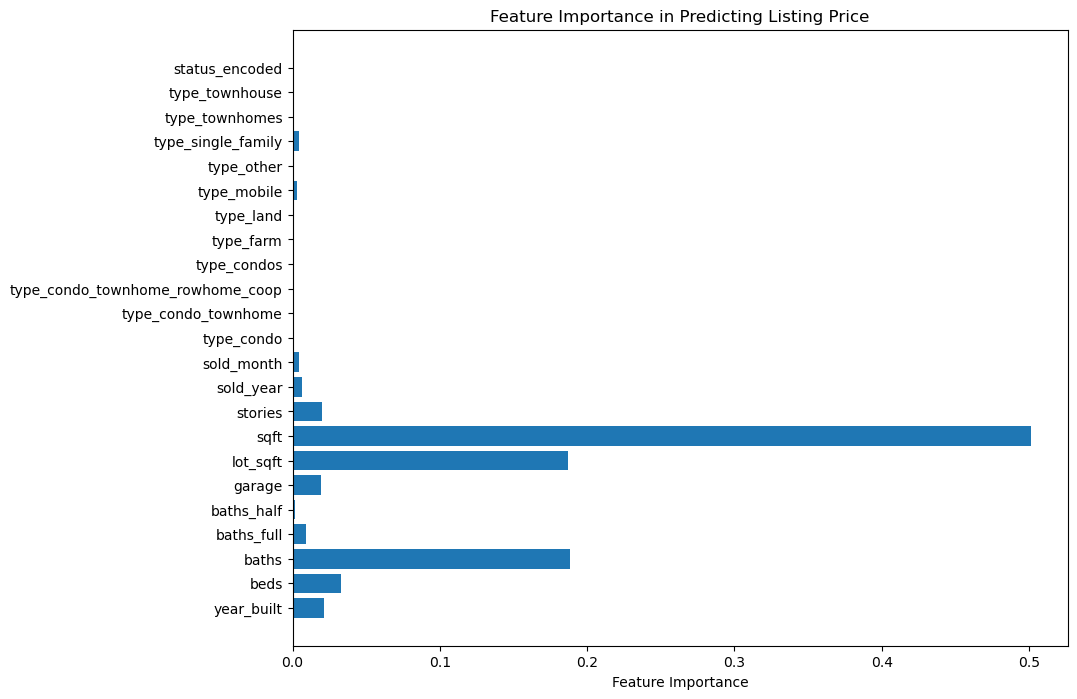

In [93]:
# Extract feature importance for the gradient boosting
feature_importances = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Listing Price")
plt.show()


This chart shows which features matter most, helping us understand what affects price most (e.g., square footage or bathrooms).

Feature Importance Interpretation

- Top Features:

  - sqft (importance: 0.513) is the most important feature, suggesting that the size of the house in square feet plays a critical role in predicting the target variable.
  - lot_sqft (importance: 0.211) indicates that the size of the lot also contributes significantly to the model's predictions.

- Moderate Importance:

  - baths (0.087), year_built (0.046), beds (0.030), and sold_month (0.020) all have moderate importance, indicating they are relevant but not as crucial as sqft or lot_sqft.

- Low Importance:

  - Features like type_condo, type_other, and status_encoded have very low importance (close to zero), suggesting that these features do not contribute meaningfully to predicting the target variable in this case.

In [95]:
# Prediction using the best model
y_pred = best_gb.predict(X_test_prepared)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 231322.2802394274
Mean Squared Error: 255156727462.53174
R-squared: 0.6522928562101715


## Summary of Findings 